In [1]:
 #!pip install torch

In [2]:
# SUbmitted in report 2025-04-20

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 0, Loss: 0.05890306457877159


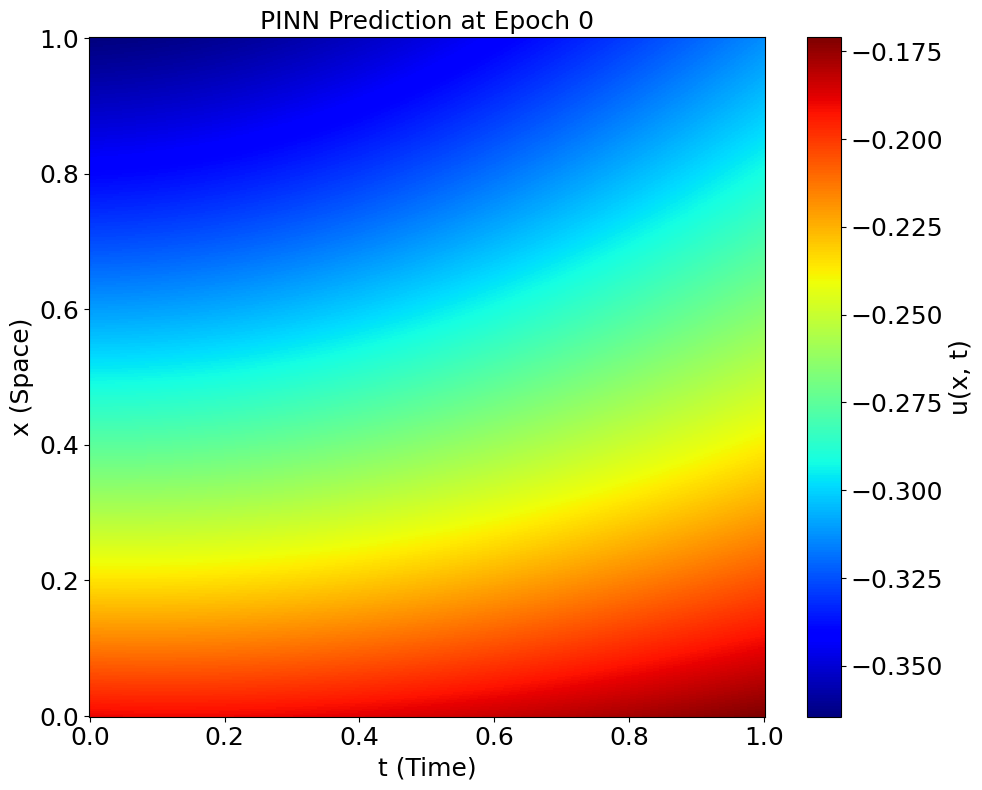

Epoch 100, Loss: 0.024311283603310585
Epoch 200, Loss: 0.015454334206879139
Epoch 300, Loss: 0.017052315175533295
Epoch 400, Loss: 0.008130520582199097
Epoch 500, Loss: 0.007518390193581581
Epoch 600, Loss: 0.009147422388195992
Epoch 700, Loss: 0.00686852028593421
Epoch 800, Loss: 0.00740772532299161
Epoch 900, Loss: 0.006282651796936989
Epoch 1000, Loss: 0.005862397141754627


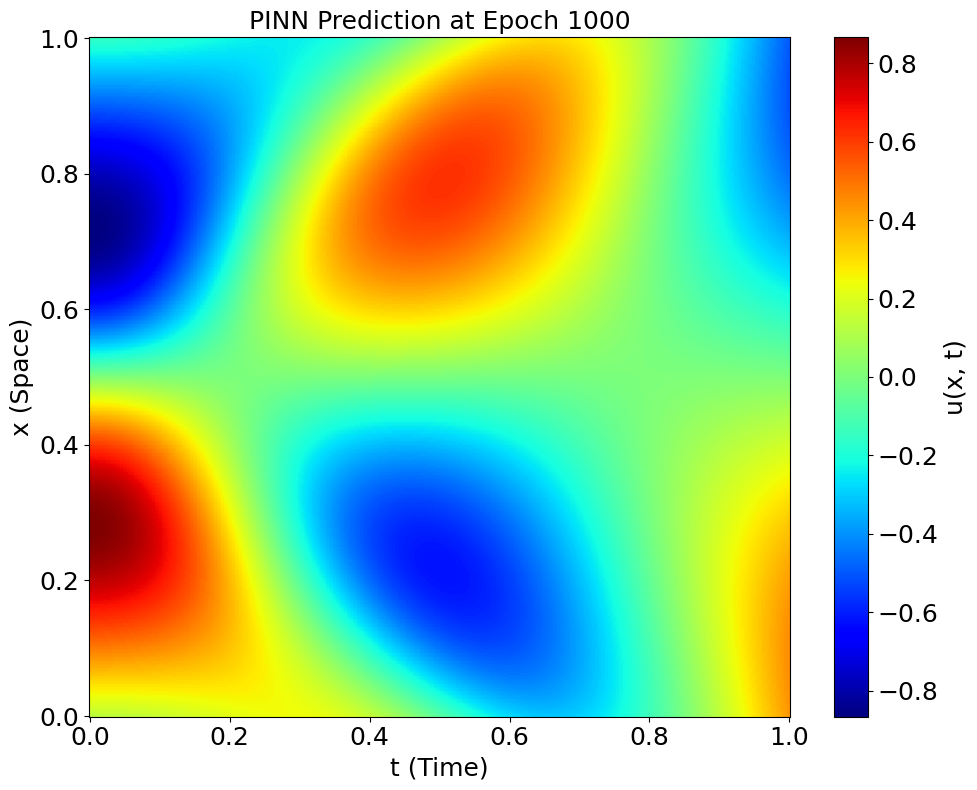

Epoch 1100, Loss: 0.005621796008199453
Epoch 1200, Loss: 0.005365415010601282
Epoch 1300, Loss: 0.0050722393207252026
Epoch 1400, Loss: 0.00472798477858305
Epoch 1500, Loss: 0.004421543329954147
Epoch 1600, Loss: 0.006099802907556295
Epoch 1700, Loss: 0.006643376313149929
Epoch 1800, Loss: 0.00326235662214458
Epoch 1900, Loss: 0.002960189478471875
Epoch 2000, Loss: 0.0026492951437830925


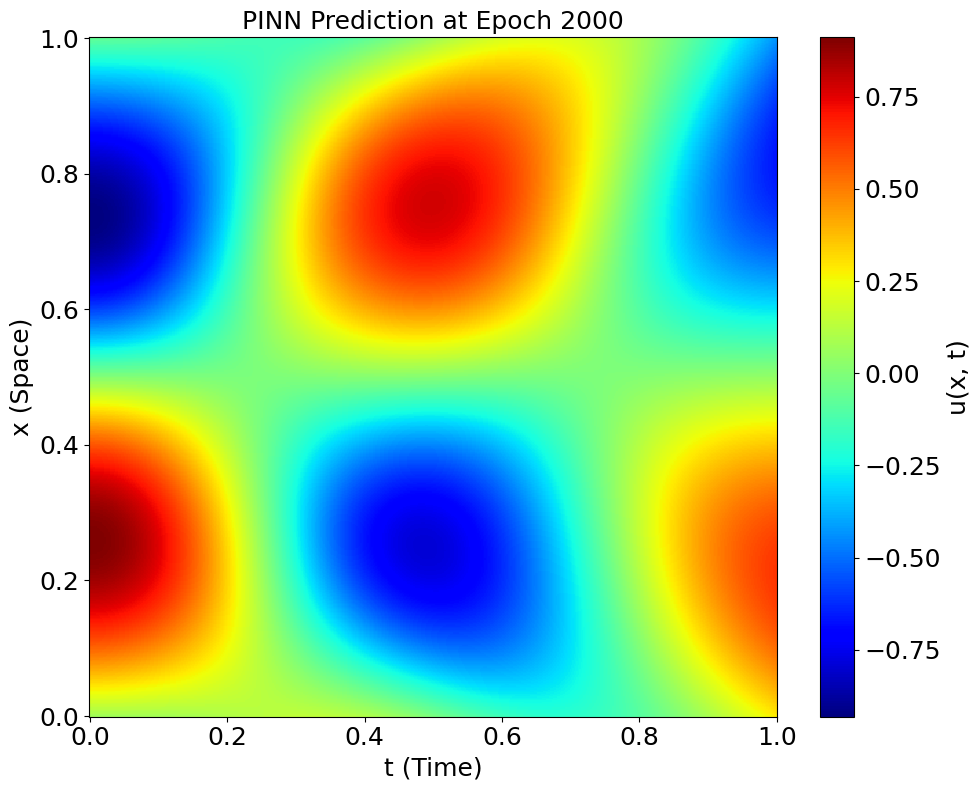

Epoch 2100, Loss: 0.0023040014784783125
Epoch 2200, Loss: 0.0025179481599479914
Epoch 2300, Loss: 0.0023079984821379185
Epoch 2400, Loss: 0.0014064741553738713
Epoch 2500, Loss: 0.001217550365254283
Epoch 2600, Loss: 0.001089814119040966
Epoch 2700, Loss: 0.0009717178181745112
Epoch 2800, Loss: 0.0008608764037489891
Epoch 2900, Loss: 0.0007587542058899999
Epoch 3000, Loss: 0.0006667803390882909


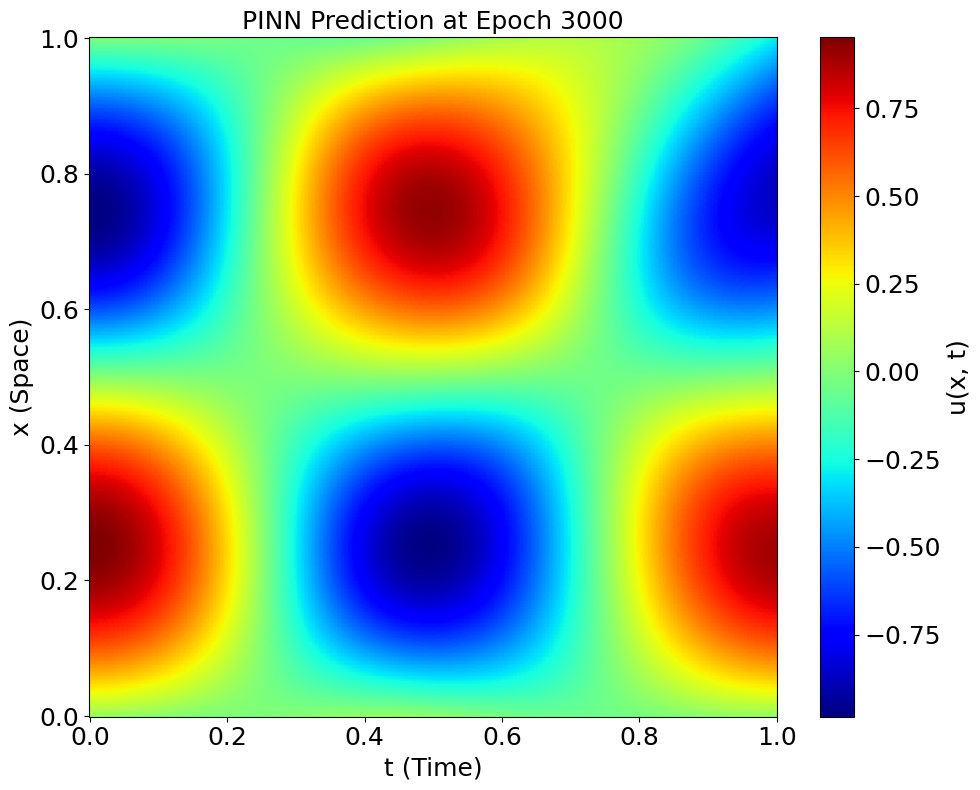

Epoch 3100, Loss: 0.0005857052747160196
Epoch 3200, Loss: 0.0005153828533366323
Epoch 3300, Loss: 0.00045496149687096477
Epoch 3400, Loss: 0.0014662911416962743
Epoch 3500, Loss: 0.00036839378299191594
Epoch 3600, Loss: 0.00033154943957924843
Epoch 3700, Loss: 0.0003692611353471875
Epoch 3800, Loss: 0.00027747859712690115
Epoch 3900, Loss: 0.0002862056135199964
Epoch 4000, Loss: 0.00023496232461184263


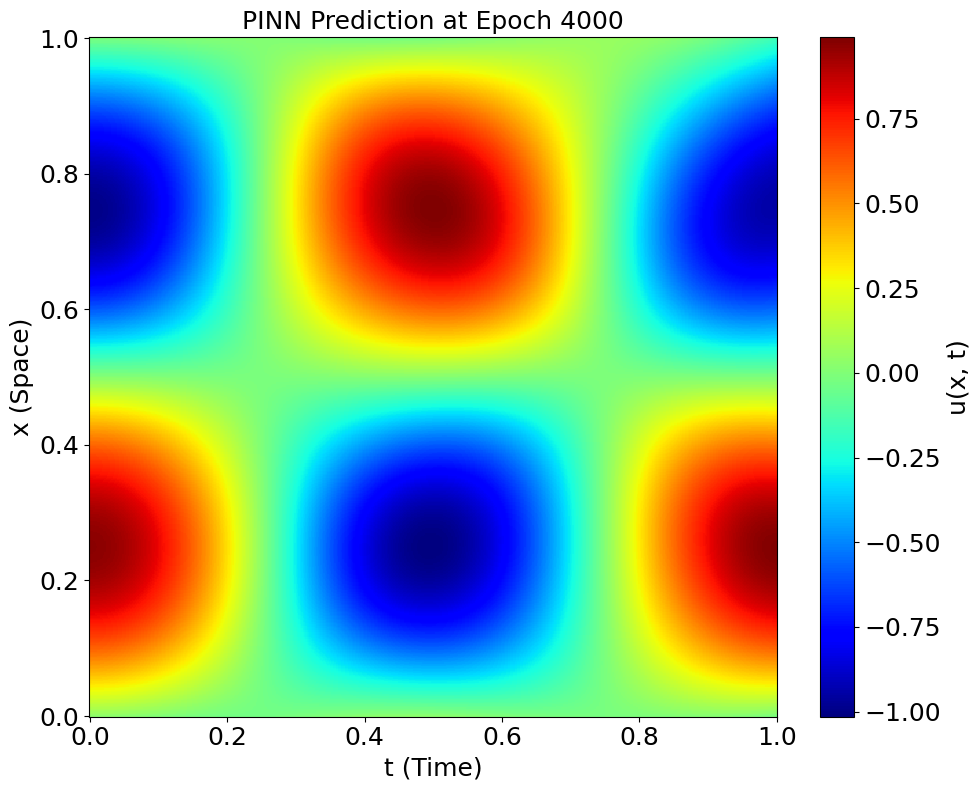

Epoch 4100, Loss: 0.0002207147772423923
Epoch 4200, Loss: 0.00021175315487198532
Epoch 4300, Loss: 0.0001987558207474649
Epoch 4400, Loss: 0.00019268051255494356
Epoch 4500, Loss: 0.00018671335419639945
Epoch 4600, Loss: 0.00018084078328683972
Epoch 4700, Loss: 0.0001750527007970959
Epoch 4800, Loss: 0.0001693513331701979
Epoch 4900, Loss: 0.0001637406530790031
Epoch 5000, Loss: 0.0001582280674483627


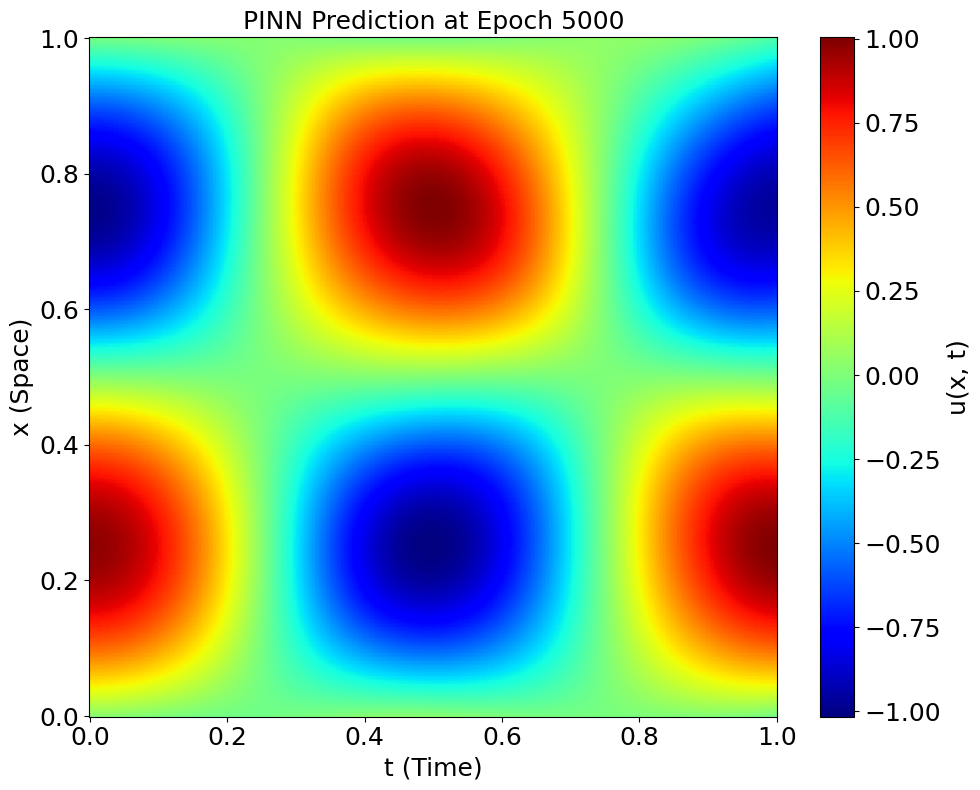

Epoch 5100, Loss: 0.00015282128879334778
Epoch 5200, Loss: 0.00014752784045413136
Epoch 5300, Loss: 0.0001423573849024251
Epoch 5400, Loss: 0.00013731885701417923
Epoch 5500, Loss: 0.0001324206532444805
Epoch 5600, Loss: 0.00013047819084022194
Epoch 5700, Loss: 0.00012850049824919552
Epoch 5800, Loss: 0.0001264945894945413
Epoch 5900, Loss: 0.0001244626910192892
Epoch 6000, Loss: 0.00012240358046256006


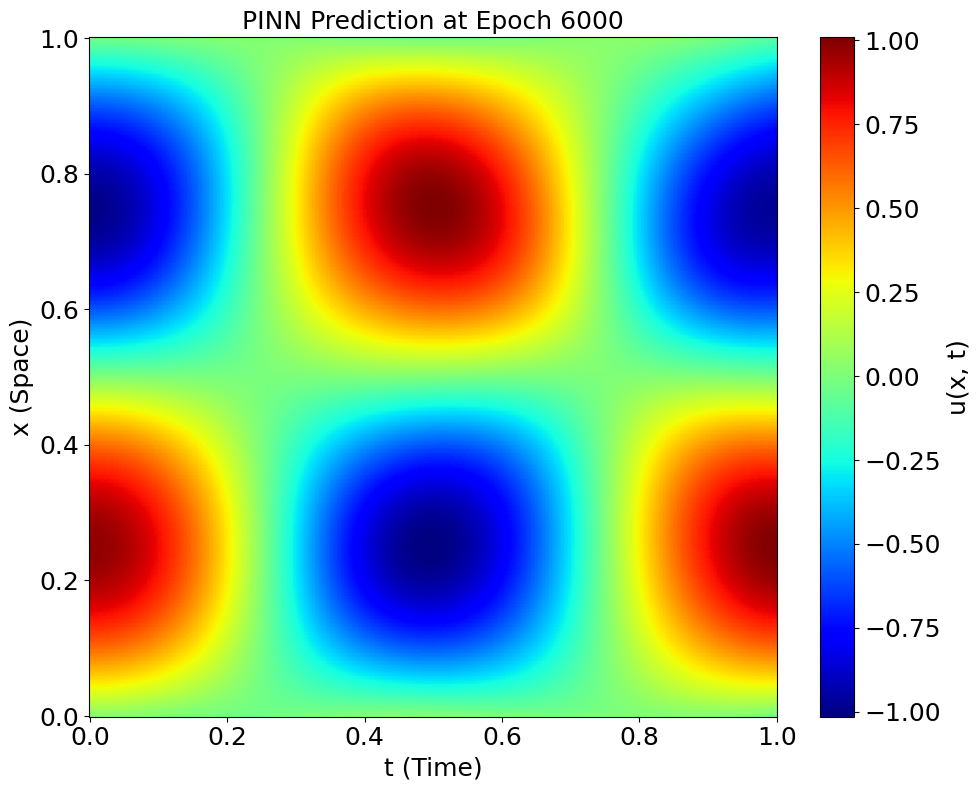

Epoch 6100, Loss: 0.00012032191443722695
Epoch 6200, Loss: 0.00011822230590041727
Epoch 6300, Loss: 0.00011610727233346552
Epoch 6400, Loss: 0.00011397992784623057
Epoch 6500, Loss: 0.00011184408504050225
Epoch 6600, Loss: 0.00010970255243591964
Epoch 6700, Loss: 0.00010756173287518322
Epoch 6800, Loss: 0.00010542207746766508
Epoch 6900, Loss: 0.00010329001815989614


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

torch.manual_seed(123)
drive.mount('/content/drive')
save_dir = '/content/drive/My Drive/PINN_results_20th'
os.makedirs(save_dir, exist_ok=True)

#the exact solution
def exact_solution(x, t, A, c, phi):
    return A * np.sin(phi * np.pi * x) * np.cos(c * phi * np.pi * t)

#  the PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = nn.Sequential(
            nn.Linear(2, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.hidden_layers(inputs)

#  the residual for the wave equation
def wave_equation_residual(model, x, t, c):
    u_pred = model(x, t)
    u_x = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_t = torch.autograd.grad(u_pred, t, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u_t), create_graph=True)[0]
    return u_tt - c**2 * u_xx


# Training  setup
A = 1.0
phi = 2.0
c = 1
N_boundary = 200
N_physics = 1400
N_epochs = 7000

lr=1e-2
lambda1 = 1e-1
lambda2 = 1e-1
lambda3 = 2e-1
lambda4 = 1e-1

# Collocation points
x_bc = torch.cat([torch.zeros(N_boundary, 1), torch.ones(N_boundary, 1)], dim=0).requires_grad_(True)
t_bc = torch.rand(2 * N_boundary, 1).requires_grad_(True)
x_physics = torch.rand(N_physics, 1).requires_grad_(True)
t_physics = torch.rand(N_physics, 1).requires_grad_(True)


model = PINN()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 1000, 2500, 4200, 5500,7500], gamma=0.40)

loss_list = []
loss_bc_list = []
loss_ic_list = []
loss_ic_t_list = []
loss_pde_list = []


def plot_predictions(epoch, model):
    x_test = torch.linspace(0, 1, 500).view(-1, 1)
    t_test = torch.linspace(0, 1, 500).view(-1, 1)
    T, X = np.meshgrid(t_test.numpy(), x_test.numpy())

    T_tensor = torch.tensor(T.flatten(), dtype=torch.float32).view(-1, 1)
    X_tensor = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1)

    with torch.no_grad():
        u_pred = model(X_tensor, T_tensor).detach().numpy().reshape(X.shape)


    plt.figure(figsize=(10, 8))
    im = plt.pcolormesh(T, X, u_pred, cmap='jet', shading='auto')

    cbar = plt.colorbar(im)
    cbar.set_label('u(x, t)', fontsize=18)
    cbar.ax.tick_params(labelsize=18)
    plt.xlabel('t (Time)',fontsize=18, color='black')
    plt.ylabel('x (Space)',fontsize=18, color='black')
    plt.xticks(fontsize=18, color='black')
    plt.yticks(fontsize=18, color='black')
    plt.title(f'PINN Prediction at Epoch {epoch}',fontsize=18, color='black')
    plt.tight_layout()

    plot_path = os.path.join(save_dir, f'PINN_prediction_epoch_{epoch}.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    # print(f'Prediction plot saved at: {plot_path}')

for epoch in range(N_epochs):
    optimizer.zero_grad()

    u_bc = model(x_bc, t_bc)
    loss_bc = torch.mean(u_bc**2)

    u_ic = model(x_physics, torch.zeros_like(x_physics))
    u_ic_exact = A * torch.sin(phi * np.pi * x_physics)
    loss_ic = torch.mean((u_ic - u_ic_exact)**2)

    t_zeros = torch.zeros_like(x_physics, requires_grad=True)
    u_t_ic = torch.autograd.grad(model(x_physics, t_zeros), t_zeros, grad_outputs=torch.ones_like(t_zeros), create_graph=True)[0]
    loss_ic_t = torch.mean(u_t_ic**2)

    residual = wave_equation_residual(model, x_physics, t_physics, c)
    loss_pde = torch.mean(residual**2)


    loss = lambda1* loss_bc + lambda2* loss_ic + lambda3* loss_ic_t + lambda4 * loss_pde
    loss.backward()
    optimizer.step()
    scheduler.step()
    loss_list.append(loss.item())
    loss_bc_list.append(loss_bc.item())
    loss_ic_list.append(loss_ic.item())
    loss_ic_t_list.append(loss_ic_t.item())
    loss_pde_list.append(loss_pde.item())

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

    if epoch % 1000 == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, f'model_epoch_{epoch}.pt'))
        plot_predictions(epoch, model)


loss_dir= os.path.join('/content/drive/My Drive/PINN_results_20th')
os.makedirs(loss_dir, exist_ok=True)



loss_list = np.array(loss_list)
loss_bc_list = np.array(loss_bc_list)
loss_ic_list = np.array(loss_ic_list)
loss_ic_t_list = np.array(loss_ic_t_list)
loss_pde_list = np.array(loss_pde_list)
np.savetxt(os.path.join(loss_dir, "total_loss.txt"), loss_list, fmt="%.6f")
np.savetxt(os.path.join(loss_dir, "boundary_loss.txt"), loss_bc_list, fmt="%.6f")
np.savetxt(os.path.join(loss_dir, "initial_condition_loss.txt"), loss_ic_list, fmt="%.6f")
np.savetxt(os.path.join(loss_dir, "time_derivative_loss.txt"), loss_ic_t_list, fmt="%.6f")
np.savetxt(os.path.join(loss_dir, "physics_loss.txt"), loss_pde_list, fmt="%.6f")

# plt.figure(figsize=(10, 6))
# plt.plot(loss_list, label='Total Loss', color='red', linewidth=2)
# plt.plot(loss_ic_list, label='Initial Condition Loss', color='orange', linewidth=2)
# plt.plot(loss_ic_t_list, label='Time Derivative Loss', color='green', linewidth=2)
# plt.plot(loss_bc_list, label='Boundary Loss', color='blue', linewidth=2)
# plt.plot(loss_pde_list, label='Physics Loss', color='black', linewidth=2)

# plt.title('Loss Curves per Epoch', fontsize=18, color='black')
# plt.xlabel('Epoch', fontsize=18)
# plt.ylabel('Loss', fontsize=18)
# plt.xticks(fontsize=18, color='black')
# plt.yticks(fontsize=18, color='black')
# plt.legend(fontsize=18)
# plt.grid()
# plt.yscale('log')
# plot_path = os.path.join(save_dir, "loss_plot.png")
# plt.savefig(plot_path, dpi=300, bbox_inches='tight')
# plt.show()
# print(f" Loss plot saved at: {plot_path}")


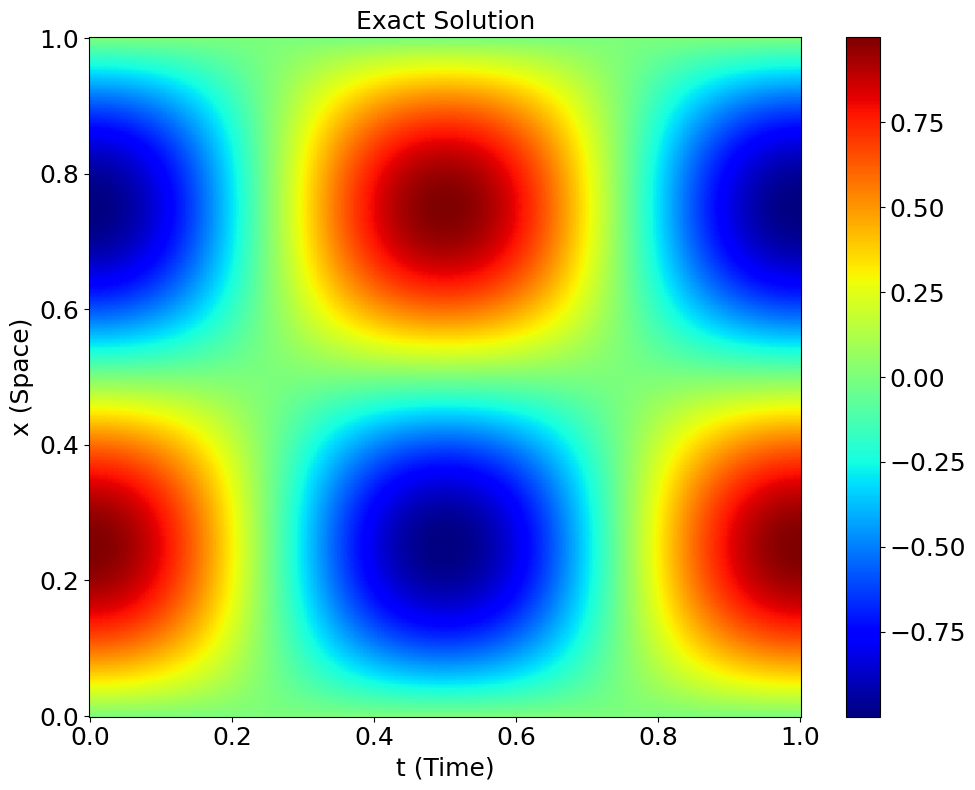

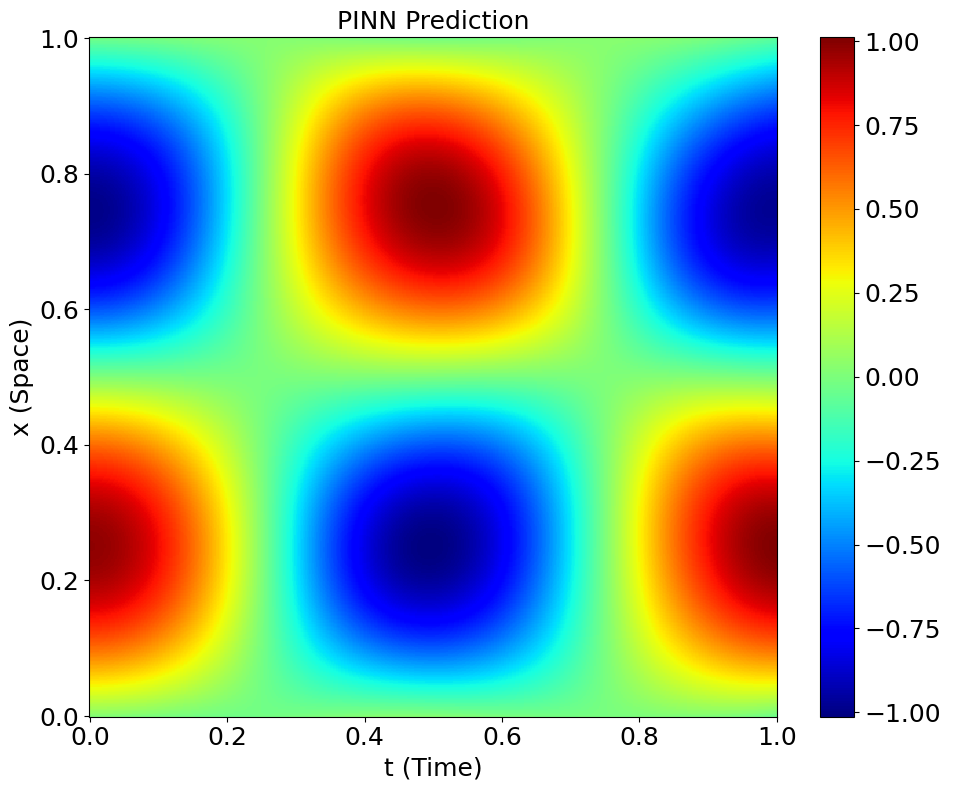

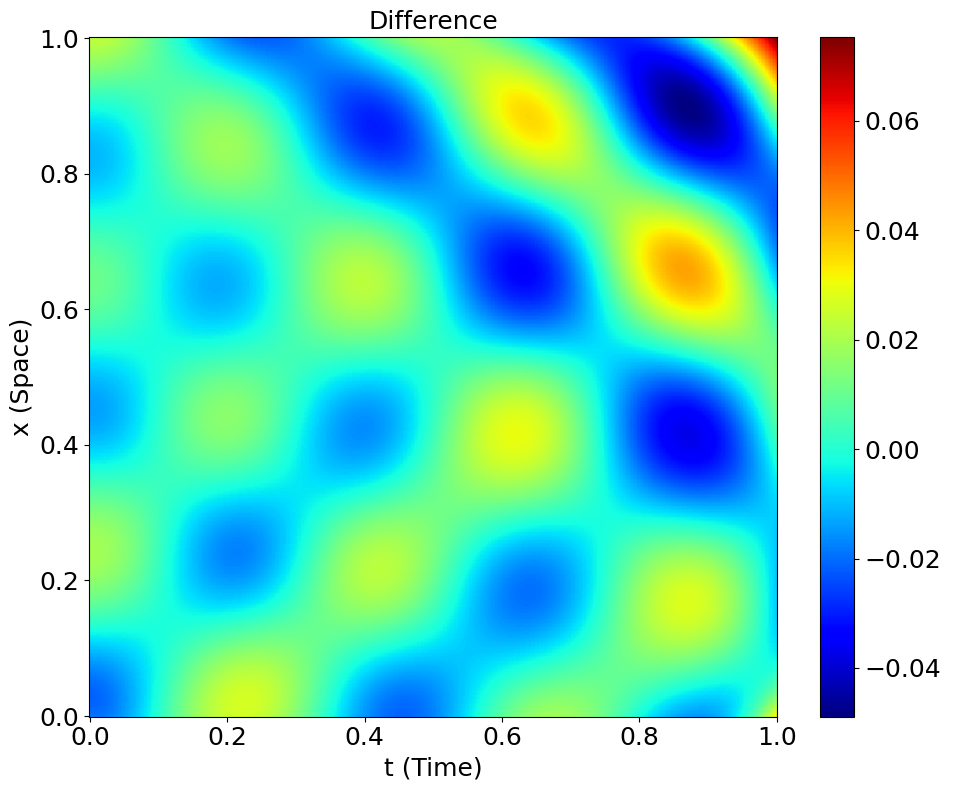

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os


save_dir = "/content/drive/My Drive/_20th"
os.makedirs(save_dir, exist_ok=True)

x_test = torch.linspace(0, 1, 500).view(-1, 1)
t_test = torch.linspace(0, 1, 500).view(-1, 1)
T, X = np.meshgrid(t_test.numpy(), x_test.numpy())
T_tensor = torch.tensor(T.flatten(), dtype=torch.float32).view(-1, 1)
X_tensor = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1)
u_pred = model(X_tensor, T_tensor).detach().numpy().reshape(X.shape)
u_exact = exact_solution(X, T, A, c, phi)
u_diff = u_exact - u_pred

def save_plot(data, title, filename, colorbar_label):
    plt.figure(figsize=(10, 8))
    im = plt.pcolormesh(T, X, data, cmap='jet', shading='auto')
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(colorbar_label, fontsize=18)
    plt.xlabel('t (Time)', fontsize=18, color='black')
    plt.ylabel('x (Space)', fontsize=18, color='black')
    plt.title(title, fontsize=18, color='black')
    plt.xticks(fontsize=18, color='black')
    plt.yticks(fontsize=18, color='black')
    plt.grid(False)
    plt.tight_layout()

    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path, dpi=400, bbox_inches='tight')
    plt.show()


save_plot(u_exact, 'Exact Solution', "exact_solution_wave_equation_2d.png", "")
final_epoch = epoch
save_plot(u_pred, f'PINN Prediction',
          f"PINN_prediction_final_epoch_{final_epoch}.png", " ")
save_plot(u_diff, 'Difference',
          "pinn_difference_wave_equation_2d.png"," " )


In [5]:
import numpy as np
import os

relative_L2_error = np.linalg.norm(u_exact - u_pred) / np.linalg.norm(u_exact)
save_dir = "/content/drive/My Drive/PINN_results_20th"
os.makedirs(save_dir, exist_ok=True)

filename = f"L2_error_epochs{N_epochs}_Nphys{N_physics}_Nbound{N_boundary}_lr{lr}_BC{lambda1}_IC{lambda2}_ICT{lambda3}_PDE{lambda4}.txt"
filepath = os.path.join(save_dir, filename)

with open(filepath, "w") as f:
    f.write(f"Relative L2 Error: {relative_L2_error:.6e}\n")
    print(f"Relative L2 Error: {relative_L2_error:.6e} (Saved as {filepath})")


Relative L2 Error: 3.041320e-02 (Saved as /content/drive/My Drive/PINN_results_20th/L2_error_epochs7000_Nphys1400_Nbound200_lr0.01_BC0.1_IC0.1_ICT0.2_PDE0.1.txt)


Plot saved at: /content/drive/My Drive/PINN_results_20th/loss_convergence_updated.png


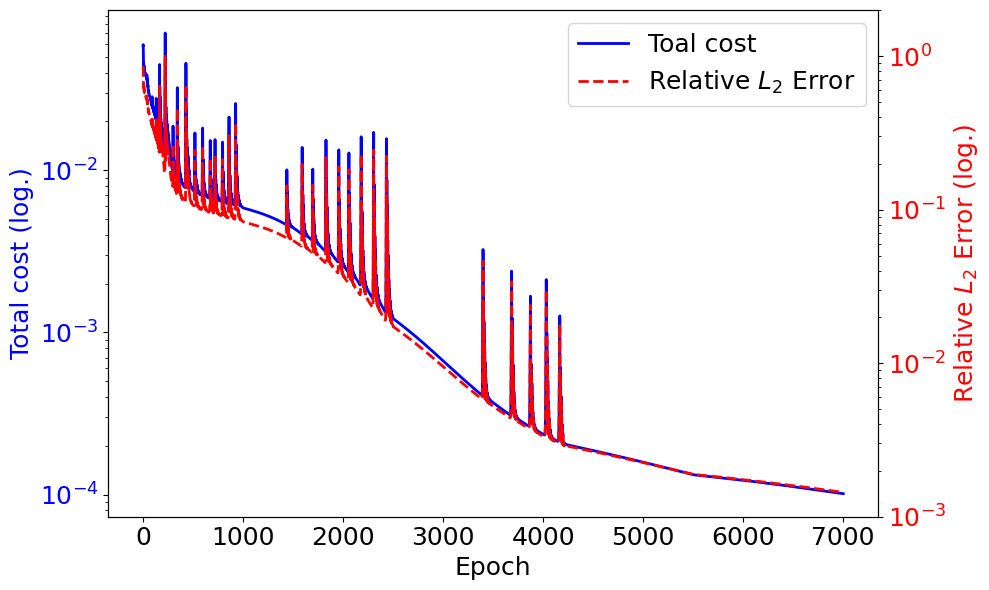

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os


save_dir = "/content/drive/My Drive/PINN_results_20th"
os.makedirs(save_dir, exist_ok=True)
iterations = np.arange(1, len(loss_list) + 1)
relative_L2_error = loss_list / np.max(loss_list)

# print("Loss list first 5 values:", loss_list[:5])
# print("Relative L2 error first 5 values:", relative_L2_error[:5])


fig, ax1 = plt.subplots(figsize=(10, 6))


ax1.set_xlabel('Epoch', fontsize=18)
ax1.set_ylabel('Total cost (log.)', color='blue', fontsize=18)
cost_plot, = ax1.plot(iterations, loss_list, label='Total cost', color='blue', linewidth=2, linestyle='solid')
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor='blue', labelsize=18)
ax1.tick_params(axis='x', labelsize=18)

ax2 = ax1.twinx()
ax2.set_ylabel('Relative $L_2$ Error (log.)', color='red', fontsize=18)
error_plot, = ax2.plot(iterations, relative_L2_error, label='Relative $L_2$ Error', linestyle='dashed', color='red', linewidth=2)
ax2.set_yscale('log')
ax2.set_ylim(1e-3, 2)
ax2.tick_params(axis='y', labelcolor='red', labelsize=18)

plt.legend([cost_plot, error_plot], ['Toal cost', 'Relative $L_2$ Error'], loc='upper right', fontsize=18)

fig.tight_layout()
save_path = os.path.join(save_dir, "loss_convergence_updated.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Plot saved at: {save_path}")
plt.show()
